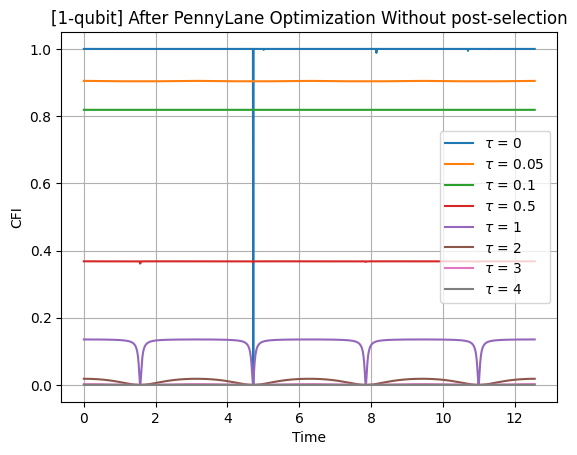

In [5]:
from enum import Enum
import random
import matplotlib.pyplot as plt
import numpy as np
import pennylane.numpy as pnp
import pennylane as qml

coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)
dev = qml.device('default.mixed', wires=1)

Tau_global = 5e-2
Paras_global = pnp.zeros(2)
Phi_global = 0
Gamma_ps = 0

class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3

def Dephase_factor(tau):
    return 1 - np.exp(-2 * tau)

@qml.qnode(dev)
def circuit(phi):
    global Tau_global, Paras_global
    
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = Paras_global

    qml.RX(pnp.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)    
    qml.RX(theta_x, wires = 0)    
    
    return qml.density_matrix(wires = 0)

def Cost_function(paras):
    global Paras_global, Phi_global
    Paras_global = paras
    phi = pnp.array([Phi_global])    
    
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    return -CFI

def PennyLaneOptimization(sweep_data, initial_parameters, gamma_ps, iterations):
    PHI = np.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze()
    
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps 
    Paras_Temporary = 0
    
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    opt = qml.GradientDescentOptimizer(stepsize=0.1)
    
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            if iteration == 1:
                Paras_Temporary = initial_parameters
            else:
                Paras_Temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            Phi_global = phi_current
            
            for _ in range(100):
                Paras_Temporary = opt.step(Cost_function, Paras_Temporary)
                
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Cost_function(Paras_Temporary)
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Paras_Temporary
            
    return Data

tau_plot = [0, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4]
Sweep_data = np.array([0, np.pi*4, 1e-2])
Sweep_data_arange = np.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])
Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for idx, tau_current in enumerate(tau_plot):
    Tau_global = tau_current
    Paras_init = pnp.zeros(2)
    Paras_init[:2] = np.pi/2
    Gamma_ps_preset = 8e-1
    Set_Iterations = 1
    
    Optimized_Result = PennyLaneOptimization(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:, DataIndex.THETA_X.value]
    Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:, DataIndex.PHI_Z.value]
    
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label=f'$\\tau$ = {tau_current}')
    
plt.title(f'[1-qubit] After PennyLane Optimization Without post-selection')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()


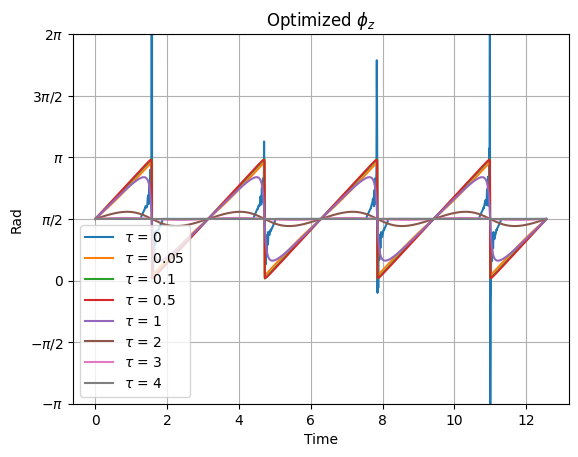

In [9]:
for idx, tau in enumerate(tau_plot):
    # if idx, tau != 4:
        plt.plot(Sweep_data_arange, Para_store[idx][:, 1], label = f'$\\tau$ = {tau}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
# plt.yticks([-np.pi, 0, np.pi, 2*np.pi], ['$-\pi$', '0', '$\pi$', '$2\pi$'])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-np.pi, 2*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

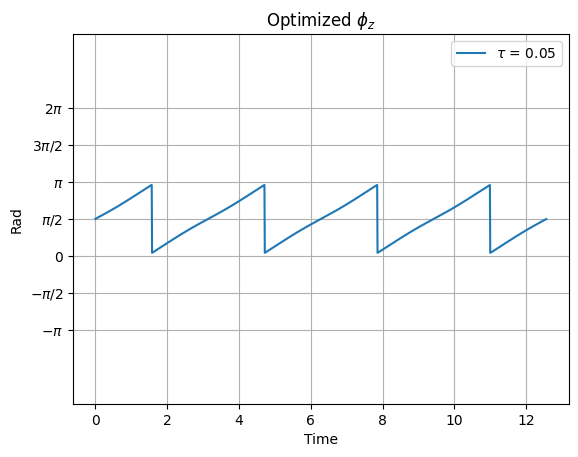

In [24]:
slice = int(len(Sweep_data_arange) / 1)

tau_order = 1,

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-2*np.pi, 3*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

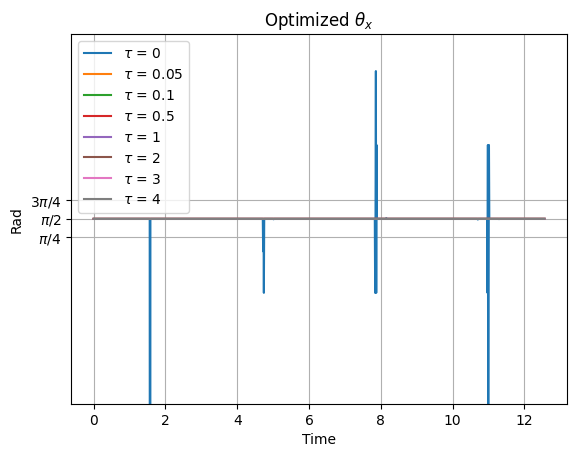

In [22]:
for idx, tau in enumerate(tau_plot):
    plt.plot(Sweep_data_arange, Para_store[idx][:, 0], label = f'$\\tau$ = {tau}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])
plt.ylim(-2*np.pi, 3*np.pi)

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()